In [1]:
# imports
import openai
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import math
from sklearn.metrics import silhouette_score

openai.api_key = os.getenv("OPENAI_API_KEY")
COMPLETIONS_MODEL = "text-davinci-003"

# This path leads to a file with data and precomputed embeddings
embedding_path = "data/funding_all.csv"

In [4]:
df = pd.read_csv(embedding_path)

In [5]:
embedding_df = pd.read_csv(embedding_path)

embedding_df["embedding"] = embedding_df.embedding.apply(eval).apply(np.array)

matrix = np.vstack(embedding_df.embedding.values)
matrix.shape

(3295, 1536)

5 1098 0.08904664642102993
10 1098 0.05226279958310513
15 1098 0.05135593690634744
20 1098 0.04947013674625181
25 1098 0.06216301404998826
30 1098 0.06659898658689253
35 1098 0.06580905217704824
40 1098 0.060478104367160765
45 1098 0.06204259923336476
50 1098 0.05902649224659428
55 1098 0.06171833658364219
60 1098 0.06259518587017437
65 1098 0.06503255307686255
70 1098 0.06593905778197649
75 1098 0.06641949883321233
80 1098 0.06534331536199982
85 1098 0.06717220528995554
90 1098 0.0672006833796118
95 1098 0.06998365929165519
100 1098 0.06919330856910537
105 1098 0.07035139061252133
110 1098 0.07001827101505037
115 1098 0.07034109278660355
120 1098 0.07039627403049943
125 1098 0.07089272662099062
130 1098 0.0712103451268121
135 1098 0.07136109130980492
140 1098 0.07046841967155681
145 1098 0.06982741934205555
150 1098 0.0675407640472423
155 1098 0.06863903037707941
160 1098 0.06703408062474905
165 1098 0.06823238499429651
170 1098 0.06798062709999574
175 1098 0.06697148264742876
180 109

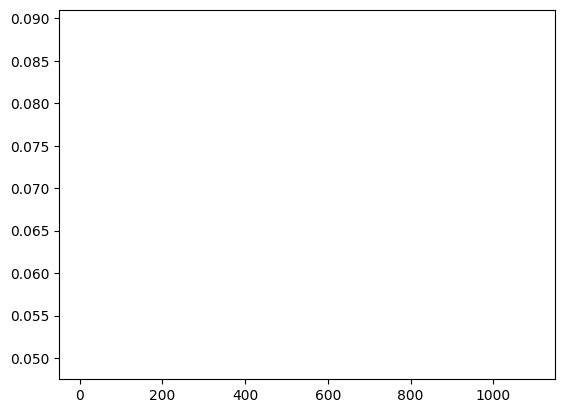

In [14]:
max_n_clusters = math.floor(len(df) / 3)

# Run KMeans for different number of clusters
cluster_results_km = pd.DataFrame({'K': range(6, max_n_clusters+1), 'SIL': np.nan})
cluster_results_km.set_index('K', inplace=True)
for k in range(5, max_n_clusters+1, 5):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(matrix)
    cluster_results_km.loc[k, 'SIL'] = silhouette_score(matrix, kmeans.labels_)
    print(k, max_n_clusters, cluster_results_km.loc[k, 'SIL'])

cluster_results_km.idxmax(), cluster_results_km.max()
# plot silhouette score
plt.plot(cluster_results_km.index, cluster_results_km.SIL)

In [22]:
# best number of clusters
n_clusters = 15 # cluster_results_km.SIL.idxmax()
n_clusters

15

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/9_/zncbh_cn5gjcfgjxhvfnznw40000gn/T/ipykernel_53294/3143629167.py:24: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(avg_x, avg_y, marker="x", color=color, s=100, edgecolors="black")
/var/folders/9_/zncbh_cn5gjcfgjxhvfnznw40000gn/T/ipykernel_53294/3143629167.py:21: RuntimeWarning: Mean of empty slice.
  avg_x = xs.mean()
/Users/jonasscholz/Library/Python/3.11/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/9_/zncbh_cn5gjcfgjxhvfnznw40000gn/T/ipykernel_53294/3143629167.py:22: Runt

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

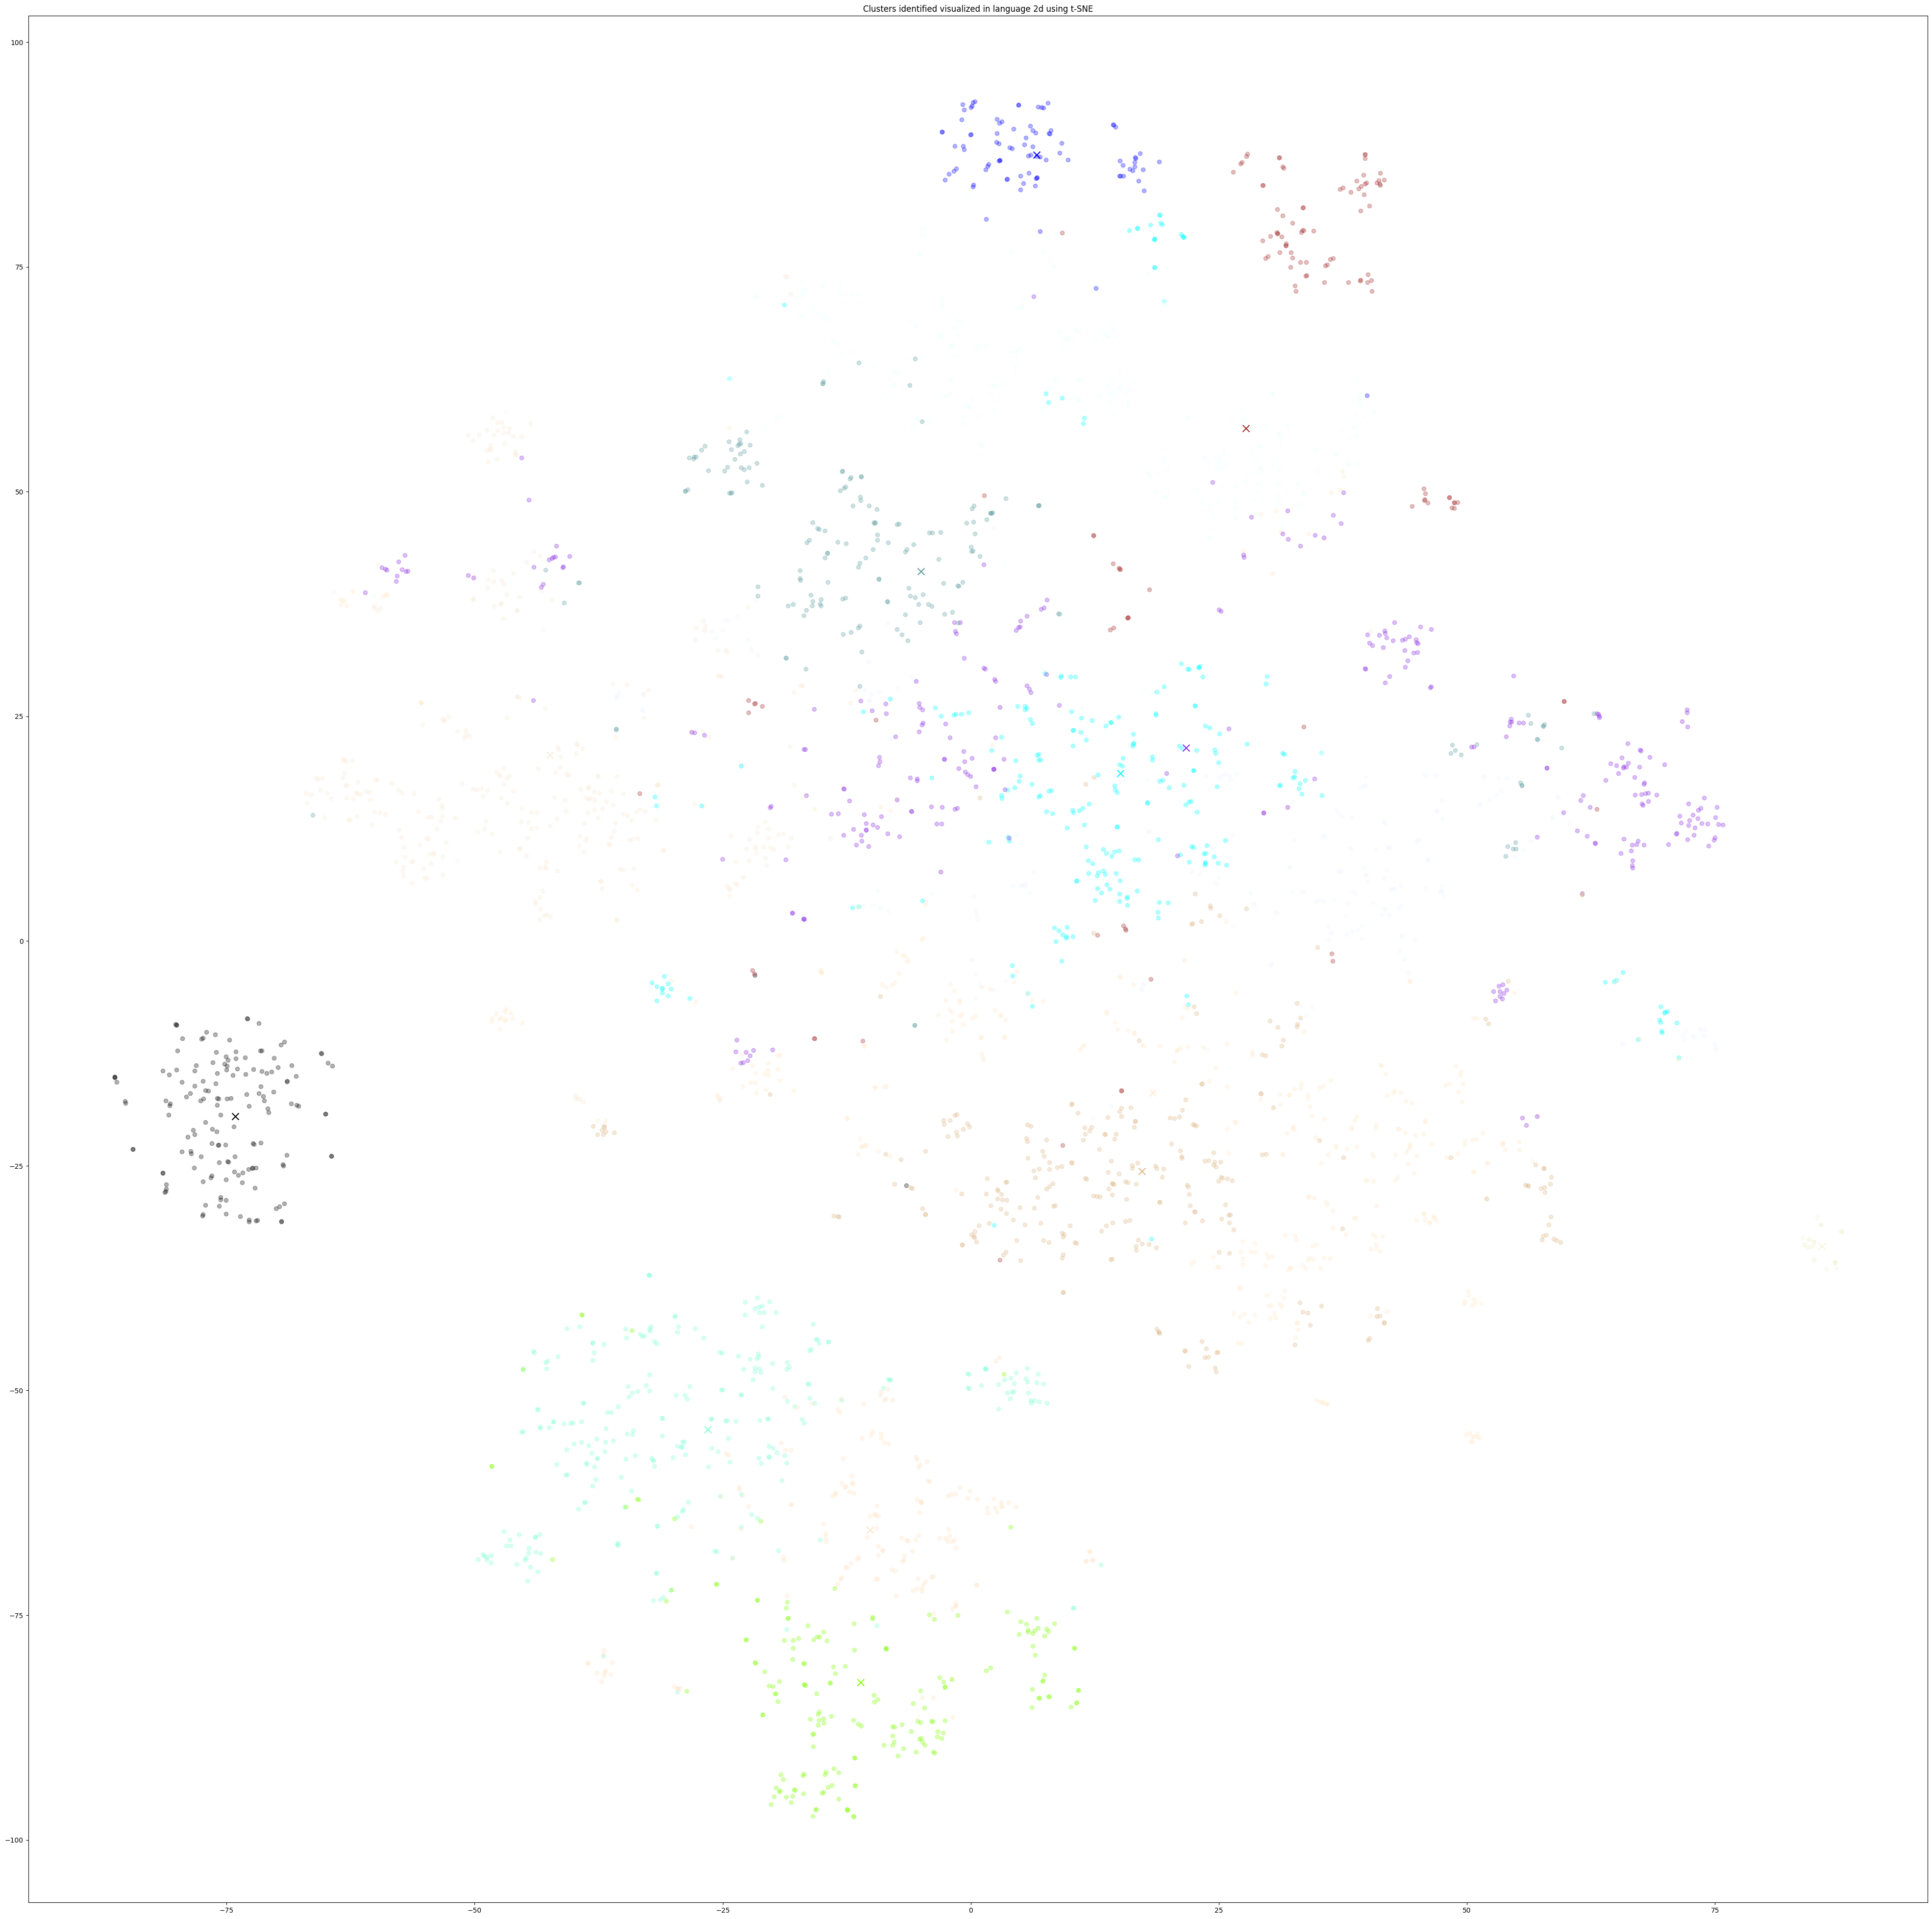

In [23]:

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
embedding_df["Cluster"] = labels

tsne = TSNE(
    n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200
)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(mcolors.CSS4_COLORS):
    xs = np.array(x)[embedding_df.Cluster == category]
    ys = np.array(y)[embedding_df.Cluster == category]
    plt.rcParams["figure.figsize"] = (50, 50)

    plt.scatter(xs, ys, color=color, alpha=0.3)
    plt.scatter(xs.mean(), ys.mean(), marker="x", color=color, s=100, edgecolors="black")
    
    




plt.title("Clusters identified visualized in language 2d using t-SNE")

Cluster 0 Theme: Cluster 1 Theme: Cluster 2 Theme: Cluster 3 Theme: Cluster 4 Theme: Cluster 5 Theme: Cluster 6 Theme: Cluster 7 Theme: Cluster 8 Theme: Cluster 9 Theme: Cluster 10 Theme: Cluster 11 Theme: Cluster 12 Theme: Cluster 13 Theme: Cluster 14 Theme: 

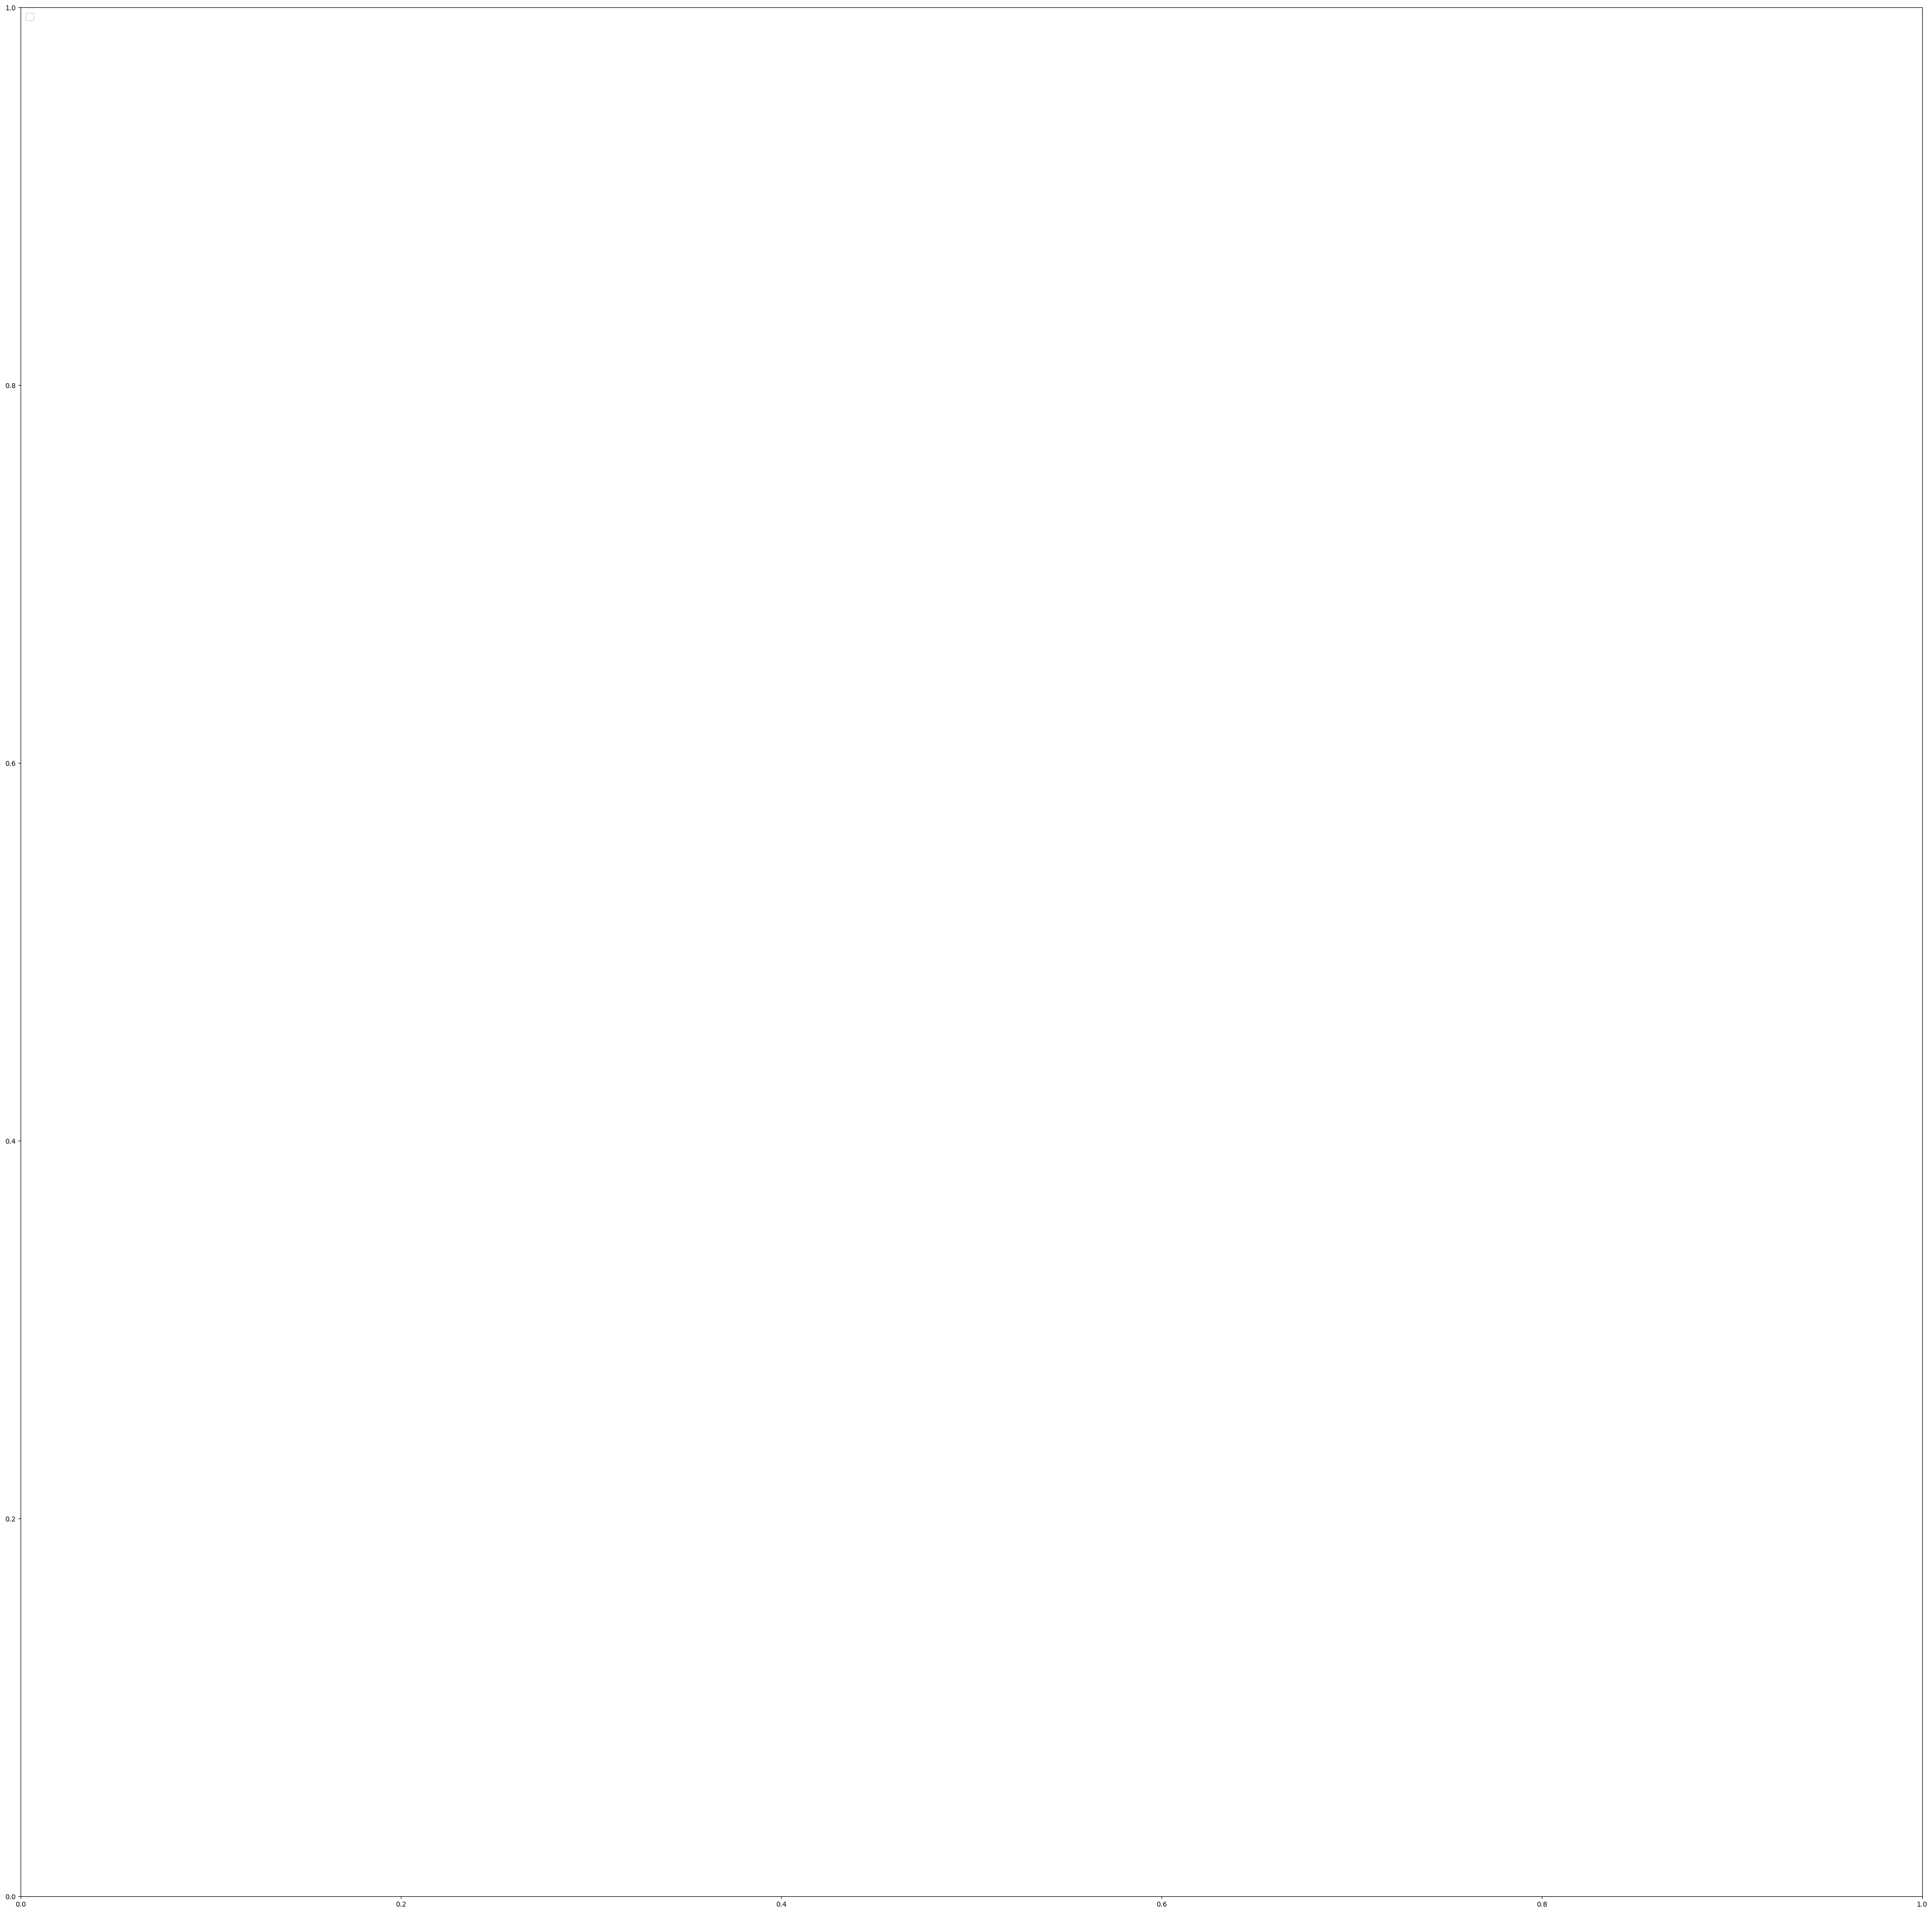

In [25]:
# We'll read 5 transactions per cluster as we're expecting some variation
transactions_per_cluster = 5

cluster_titles = []

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    funding_programs = "\n".join(
        embedding_df[embedding_df.Cluster == i]
        .title
        .sample(transactions_per_cluster, replace=True, random_state=42)
        .values
    )
    response = openai.Completion.create(
        model=COMPLETIONS_MODEL,
        # We'll include a prompt to instruct the model what sort of description we're looking for
        prompt=f'''Was haben die folgenden Förderprogramme gemeinsam?\n\Programme:\n"""\n{funding_programs}\n"""\n\nTheme:''',
        temperature=0,
        max_tokens=100,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )

        


    if response["choices"][0]["text"] == "":
        cluster_titles.append("Unknown")
    else:
        cluster_titles.append(response["choices"][0]["text"].replace("\n", ""))

    #sample_cluster_rows = embedding_df[embedding_df.Cluster == i].sample(transactions_per_cluster, random_state=42)
    #for j in range(transactions_per_cluster):
    #    print(sample_cluster_rows.title.values[j], end="\n")


plt.legend(
    cluster_titles,
    loc="upper left",
    prop={"size": 15},
)
